In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS
from astropy.time import Time
from astroplan import Observer

import astropy.units as u

from astropy.coordinates import get_moon
from astropy.coordinates import get_sun

from astropy.visualization import astropy_mpl_style, quantity_support


In [14]:
class CTA_Info:

    """
    CTA frame based on its location and a given observation time.
    
    Parameters
    ----------
    site: str, optional 
        CTA location; North (default), South, Roque de los Muchachos, or Paranal.
    time: str, optional
        Observation time (yyyy-MM-ddThh:mm:ss). Default is astropy.time.Time.now()
    verbose: bool, optional

    Returns
    -------
    class
    """

    def __init__(self, site="North", time = None, verbose=True):
        
        if time is None:
            time = Time.now()

        self._site = site
        self.site_def(site)
        self._observer = Observer(location=self.loc, name=self.name)
        self._t_obs = Time(time, format='isot', scale='utc')
        self._source = None
        self._timestep = np.linspace(-12, 12, 100)*u.hour
        if verbose:
            self.info

    @property
    def info(self):
        """
        Print information
        """
        print("Observer         : ", self.observer.name)
        print("Location         : ", self.site,  ",", self.loc.to(u.km))
        print("Observation time : ", self.t_obs)

    @property
    def loc(self):
        """
        Coordinates of observatory

        Returns
        -------
        astropy.coordinates.EarthLocation.from_geodetic
        """

        if self.site.lower() in ('north', 'roque de los muchachos'):
            site_coords = EarthLocation.from_geodetic('342.1184', '28.7606', 2326. * u.meter)
        elif self.site.lower() in ('south', 'paranal'):
            site_coords = EarthLocation.from_geodetic('289.5972', '-24.6253', 2635. * u.meter)
        else:
            raise Warning(f"{site} is not a valid site choice")
        return site_coords
    
    @property
    def t_obs(self):
        """
        Observation time

        Returns
        -------
        astropy.time
        """
        return self._t_obs

    @property
    def observer(self):
        """
        A container class for information about an observer’s location and environment.
        
        Returns
        -------
        astroplan.Observer
        """
        return self._observer
    
    @property
    def altaz(self):
        """
        An AltAz frame based on the observation time and location.
        
        Returns
        -------
        astropy.astropy.coordinates.AltAz
        """
        return AltAz(obstime=self.t_obs, location=self.loc)

    @property
    def site(self):
        """
        The location of observatory; Roque de los Muchachos or Paranal
        
        Returns
        -------
        str
        """
        return self._site

    @property
    def name(self):
        """
        The name of observatory; CTA North or CTA South

        Returns
        -------
        str
        """
        return self._name

    @property
    def source(self):
        """
        Return the sky coordinate of a source, which is defined by
        CTA_Info.set_source_loc.

        Returns
        -------
        astropy.coordinates.SkyCoord
        """
        return self._source

    def _time_bin(self, timestep):
        """
        Return an array of time, t_obs+timestep.
        
        Parameters
        ----------
        timestep: array, astropy.Quantity
            If timestep does not have an unit, it is assumed to be hour.
            default: np.linspace(-12, 12, 100)*u.hour
        """
        if timestep is not None:
            if type(timestep) != u.Quantity:
                print("[Warning] The unit of timestep is assumed to be 'hour'.")
                self._timestep = timestep*u.hour
            else:
                self._timestep = timestep
        
        time = self.t_obs+self._timestep
        return time

    def site_def(self, site):
        """
        Define a site of observatory.
        
        Parameters
        ----------
        site: str 
              CTA location; North (default), South, Roque de los Muchachos, or Paranal.
        """
        if self.site.lower() in ('north', 'roque de los muchachos'):
            self._site = "Roque de los Muchachos"
            self._name = "CTA North"
        elif self.site.lower() in ('south', 'paranal'):
            self._site = "Paranal"
            self._name = "CTA South"
        else:
            raise Warning(f"{site} is not a valid site choice")

    def get_sun_loc(self, timespan=False, timestep=None):
        """
        Return Sun location given time and location.
        
        Parameters
        ----------
        timespan: bool, optional 
            If True, it returns the location of Moon as a function of time
        timestep: array, astropy.Quantity, optional 
            When timespan is True, timestep can be optioanlly used.
            See CTA_Info._time_bin

        Returns
        -------
        astropy.coordinates.get_sun
        """

        if timespan:
            time = self._time_bin(timestep)
        else:
            time = self.t_obs

        frame = AltAz(obstime=time, location=self.loc)
        return get_sun(time).transform_to(frame)

    def get_moon_loc(self, timespan=False, timestep=None):
        """
        Return Moon location given time and location.
        
        Parameters
        ----------
        timespan: bool, optional 
            If True, it returns the location of Moon as a function of time
        timestep: array, astropy.Quantity, optional 
            When timespan is True, timestep can be optioanlly used.
            See CTA_Info._time_bin

        Returns
        -------
        astropy.coordinates.get_moon
        """
        if timespan:
            time = self._time_bin(timestep)
        else:
            time = self.t_obs

        frame = AltAz(obstime=time, location=self.loc)
        return get_moon(time).transform_to(frame)

    def set_source_loc(self, ra, dec, timespan=False, timestep=None, units='deg'):
        """
        Set a source location with a given frame.
        
        Parameters
        ----------
        ra: float
            Right ascension of a source
        dec: float 
            Declination of a source
        units: str
            Units of RA and DEC; either deg (default) or rad
        timespan: bool, optional 
            If True, it returns the location of Moon as a function of time
        timestep: array, astropy.Quantity, optional 
            When timespan is True, timestep can be optioanlly used.
            See CTA_Info._time_bin
        Returns
        -------
        astropy.coordinates.SkyCoord
        """

        source_radec = SkyCoord(ra=ra, dec=dec, frame=ICRS, unit=units)
        
        if timespan:
            time = self._time_bin(timestep)
            frame = AltAz(obstime=time, location=self.loc)
            src = source_radec.transform_to(frame)
        else:
            src = source_radec.transform_to(self.altaz)
            self._source = src
        
        return src
    
    def update(self, site=None, time=None, delta_t=None, verbose=False):
        """
        Update site and/or observation time.
        
        Parameters
        ----------
        site: str, optional
            Updated site name
        time: str, optional 
            Updated observation time (yyyy-MM-ddThh:mm:ss)
        delta_t: astropy.Quantity, optional 
            Elapsed time from the original observation time.
            e.g., CTA_Info.update(delta_t= -0.5*u.hour) 
            -> t_new = t_old - 0.5 hour
        verbose: optional 
        """
        if site is not None:
            self._site = site
            self.site_def(site)
            self._observer = Observer(location=self.loc, name=self.name)

        elif time is not None:
            self._t_obs = Time(time, format='isot', scale='utc')

        elif delta_t is not None:
            if type(delta_t) != u.Quantity:
                print("[Warning] The units of delta_t is assumed to be 'hour'.")
                delta_t = delta_t*u.hour
            
            self._t_obs = Time(self.t_obs+delta_t, format='isot', scale='utc')            
        
        if verbose:
            self.info

    

In [15]:
cta = CTA_Info('north','2020-06-20T00:00')

Observer         :  CTA North
Location         :  Roque de los Muchachos , (5327.28509212, -1718.7771125, 3051.78673275) km
Observation time :  2020-06-20T00:00:00.000


In [16]:
cta.set_source_loc(ra=279.232102, dec=38.782316)
print ("source:", cta.source)

source: <SkyCoord (AltAz: obstime=2020-06-20T00:00:00.000, location=(5327285.09211954, -1718777.11250295, 3051786.7327476) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (59.4752045, 64.31210302)>


In [27]:
sun.alt.deg

array([ 72.78680587,  75.84740966,  78.79918184,  81.52407464,
        83.7161225 ,  84.66885403,  83.78293208,  81.62315634,
        78.91149048,  75.96572903,  72.90820237,  69.79147713,
        66.64128158,  63.47170413,  60.29122907,  57.10540967,
        53.91816607,  50.73246604,  47.55070633,  44.37493909,
        41.20701404,  38.04867265,  34.90161422,  31.76754521,
        28.64821853,  25.54546697,  22.46123359,  19.3976008 ,
        16.3568196 ,  13.34134002,  10.3538434 ,   7.39727752,
         4.47489485,   1.59029471,  -1.25253054,  -4.04914484,
        -6.7946134 ,  -9.48344366, -12.10952307, -14.66605528,
       -17.14549726, -19.53950127, -21.83886723, -24.033513  ,
       -26.11247267, -28.06393488, -29.87533554, -31.53351976,
       -33.02498652, -34.33622493, -35.45414213, -36.36656935,
       -37.06281649, -37.53422847, -37.77468443, -37.78097764,
       -37.55302352, -37.0938652 , -36.40947584, -35.50838672,
       -34.40119286, -33.09999821, -31.61785964, -29.96

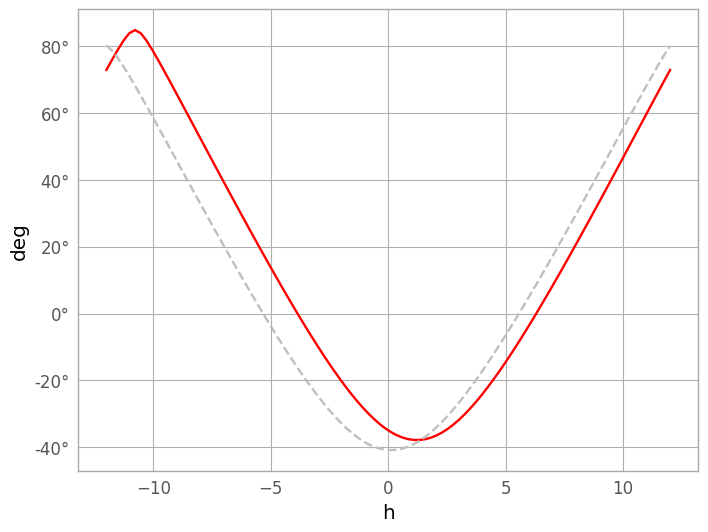

In [30]:
from astropy.visualization import astropy_mpl_style, quantity_support

plt.style.use(astropy_mpl_style)
quantity_support()
timestep= None
if timestep is not None:
    if type(timestep) != u.Quantity:
        print("[Warning] The unit of timestep is assumed to be 'hour'.")
        cta._timestep = timestep*u.hour
    else:
        cta._timestep = timestep

sun = cta.get_sun_loc(timespan=True)
moon = cta.get_moon_loc(timespan=True)
plt.plot(cta._timestep, sun.alt, color='r', label='Sun')
plt.plot(cta._timestep, moon.alt, color=[0.75]*3, ls='--', label='Moon')
ra=279.232102
dec=38.782316
units = u.deg

src = cta.set_source_loc(ra=ra, dec=dec, timespan=True, units=units)



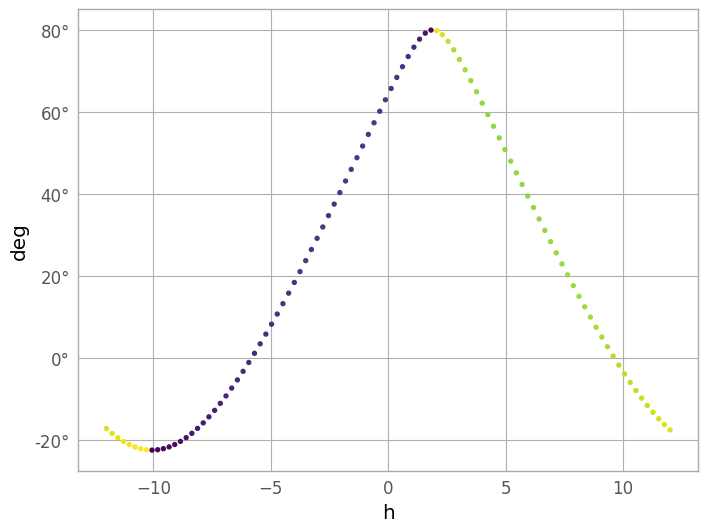

In [34]:
#plt.plot(cta._timestep, src.alt, lw=0.5, alpha=0.5, color="orange")
plt.scatter(cta._timestep, src.alt, c= src.az.value, s=8, cmap='viridis')

#plt.fill_between(cta._timestep, 0, 90*u.deg,
#                 sun.alt < -0*u.deg, color='0.5', zorder=0)
#plt.fill_between(cta._timestep, 0*u.deg, 90*u.deg,
#                 sun.alt < -18*u.deg, color='k', zorder=0)



In [ ]:
plt.colorbar().set_label('Azimuth [deg]')
plt.legend(loc='upper left')
#plt.xlim(-12*u.hour, 12*u.hour)
#plt.xticks((np.arange(13)*2-12)*u.hour)
#plt.ylim(0*u.deg, 90*u.deg)
plt.xlabel('Hours from EDT Midnight')
plt.ylabel('Altitude [deg]')
plt.show(block=False)


In [20]:
navigation_plot(cta=cta)

TypeError: only dimensionless scalar quantities can be converted to Python scalars

Error in callback <function _draw_all_if_interactive at 0x7f2ef2bc5240> (for post_execute):


TypeError: only dimensionless scalar quantities can be converted to Python scalars

TypeError: only dimensionless scalar quantities can be converted to Python scalars

<Figure size 800x600 with 2 Axes>

In [10]:
midnight = Time(f'2022-12-17T00:00:00', scale="utc") 
delta_midnight = np.linspace(-12, 12, 100)*u.hour
times = midnight + delta_midnight

In [11]:
len(delta_midnight)

100

In [12]:
sun = cta.get_sun_loc(timespan=True)
sun

<SkyCoord (AltAz: obstime=['2020-06-19T12:00:00.000' '2020-06-19T12:14:32.727'
 '2020-06-19T12:29:05.455' '2020-06-19T12:43:38.182'
 '2020-06-19T12:58:10.909' '2020-06-19T13:12:43.636'
 '2020-06-19T13:27:16.364' '2020-06-19T13:41:49.091'
 '2020-06-19T13:56:21.818' '2020-06-19T14:10:54.545'
 '2020-06-19T14:25:27.273' '2020-06-19T14:40:00.000'
 '2020-06-19T14:54:32.727' '2020-06-19T15:09:05.455'
 '2020-06-19T15:23:38.182' '2020-06-19T15:38:10.909'
 '2020-06-19T15:52:43.636' '2020-06-19T16:07:16.364'
 '2020-06-19T16:21:49.091' '2020-06-19T16:36:21.818'
 '2020-06-19T16:50:54.545' '2020-06-19T17:05:27.273'
 '2020-06-19T17:20:00.000' '2020-06-19T17:34:32.727'
 '2020-06-19T17:49:05.455' '2020-06-19T18:03:38.182'
 '2020-06-19T18:18:10.909' '2020-06-19T18:32:43.636'
 '2020-06-19T18:47:16.364' '2020-06-19T19:01:49.091'
 '2020-06-19T19:16:21.818' '2020-06-19T19:30:54.545'
 '2020-06-19T19:45:27.273' '2020-06-19T20:00:00.000'
 '2020-06-19T20:14:32.727' '2020-06-19T20:29:05.455'
 '2020-06-19T20:43:3

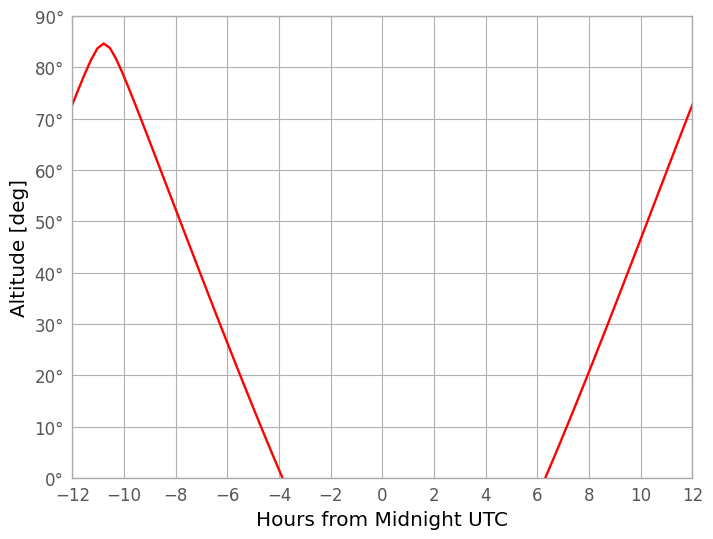

In [13]:
plt.plot(delta_midnight, sun.alt, color='r', label='Sun')
plt.xlim(-12*u.hour, 12*u.hour)
plt.xticks((np.arange(13)*2-12)*u.hour)
plt.ylim(0*u.deg, 90*u.deg)
plt.xlabel('Hours from Midnight UTC')
plt.ylabel('Altitude [deg]')
plt.show()

In [14]:
!pip install astropy==5.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 6.2 MB/s eta 0:00:00m eta 0:00:010:00:01
  Attempting uninstall: astropy
    Found existing installation: astropy 6.0.0
    Uninstalling astropy-6.0.0:
      Successfully uninstalled astropy-6.0.0
